# ML Basics - Classic Housing Example

Predict housing prices.

Method inspired (ripped off) of an [existing Kaggle submission]()

1. Read, preprocess data
2. Deal with missing values
3. Explore Features
4. Model
5. Validate

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import StackingRegressor
from sklearn import svm

/Users/jonathankim/.pyenv/versions/.mlenv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### 1. Read and Preprocess

In [2]:
train = pd.read_csv("../data/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../data/house-prices-advanced-regression-techniques/test.csv")
target = train["SalePrice"]

# all data
data = pd.concat([train, test], ignore_index=True, sort=False)
data.drop("SalePrice", axis=1, inplace=True)

data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal


In [3]:
data.describe().T.head(4)

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0


In [4]:
# Count missing values

missing = {}
for k in data.columns:
    if data[k].isnull().sum() > 0:
        missing[k] = (data[k].isnull().sum() / len(data[k]) * 100)
missing = pd.DataFrame(missing, index=["MissingValues"]).T.sort_values(by="MissingValues", ascending=False)

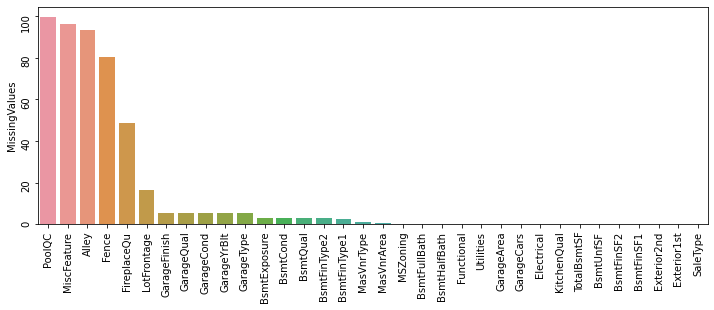

In [5]:
_, ax = plt.subplots(1, figsize=(12, 4))
ax.tick_params(labelrotation=90)
sns.barplot(y=missing.MissingValues, x=missing.index, orient='v', ax=ax);

In [6]:
data.describe(include="object").T.sort_values(by=['count']).head(10)

,count,unique,top,freq
PoolQC,10,3,Ex,4
MiscFeature,105,4,Shed,95
Alley,198,2,Grvl,120
Fence,571,4,MnPrv,329
FireplaceQu,1499,5,Gd,744
GarageCond,2760,5,TA,2654
GarageQual,2760,5,TA,2604
GarageFinish,2760,3,Unf,1230
GarageType,2762,6,Attchd,1723
BsmtExposure,2837,4,No,1904


In [7]:
data['FireplaceQu'].head(10)

0    NaN
1     TA
2     TA
3     Gd
4     TA
5    NaN
6     Gd
7     TA
8     TA
9     TA
Name: FireplaceQu, dtype: object

The data uses "NA" as "none", but is being read as a np.NaN object.

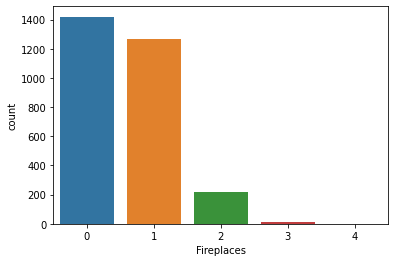

In [8]:
sns.countplot(x=data["Fireplaces"]);

In [9]:
# --- Replace "missing" values with "na" for categorical variables
categorical_variables = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'GarageCond',
                        'GarageQual', 'GarageFinish', "GarageType", 'BsmtExposure', 'BsmtFinType2',
                        'BsmtFinType1', 'BsmtQual', 'BsmtCond']
for v in categorical_variables:
    data[v].fillna("NA", inplace=True)

In [10]:
print("missing vals in MasVnr: ", data['MasVnrType'].isnull().sum())
print("Unique vals: ", data['MasVnrType'].unique())
data['MasVnrType'].fillna('None', inplace=True)

missing vals in MasVnr:  24
Unique vals:  ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]


In [11]:
# --- Fill with each var's unique highets frequency
data['Electrical'].fillna('SBrkr', inplace=True)
data['MSZoning'].fillna('RL', inplace=True)
data['Utilities'].fillna('AllPub', inplace=True)
data['Functional'].fillna('Typ', inplace=True)
data['SaleType'].fillna('WD', inplace=True)
data['Exterior2nd'].fillna('VinylSd', inplace=True)
data['Exterior1st'].fillna('VinylSd', inplace=True)
data['KitchenQual'].fillna('TA', inplace=True)

In [12]:
data.describe().T.sort_values(by="count").head(10)

,count,mean,std,min,25%,50%,75%,max
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
GarageYrBlt,2760.0,1978.113406,25.574285,1895.0,1960.0,1979.0,2002.0,2207.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtHalfBath,2917.0,0.061364,0.245687,0.0,0.0,0.0,0.0,2.0
BsmtFullBath,2917.0,0.429894,0.524736,0.0,0.0,0.0,1.0,3.0
GarageCars,2918.0,1.766621,0.761624,0.0,1.0,2.0,2.0,5.0
GarageArea,2918.0,472.874572,215.394815,0.0,320.0,480.0,576.0,1488.0
TotalBsmtSF,2918.0,1051.777587,440.766258,0.0,793.0,989.5,1302.0,6110.0
BsmtUnfSF,2918.0,560.772104,439.543659,0.0,220.0,467.0,805.5,2336.0
BsmtFinSF2,2918.0,49.582248,169.205611,0.0,0.0,0.0,0.0,1526.0


### Fill LotFrontage

`LotFrontage` has the most missing values by a lot. Fill it in by associating it with something else. Something obvious

<AxesSubplot:xlabel='LotArea', ylabel='Count'>

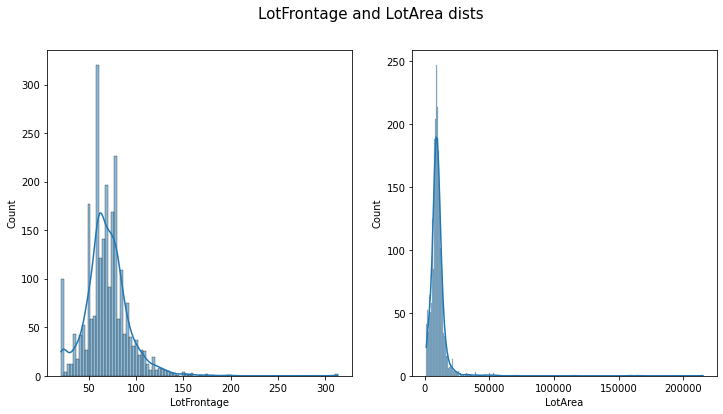

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("LotFrontage and LotArea dists", size=15)
sns.histplot(x=data.LotFrontage, kde=True, ax=ax[0])
sns.histplot(x=data.LotArea, kde=True, ax=ax[1])

1. Calcualte Z-score
2. Remove outliers
3. Compare to prices

In [14]:
lot_tmp = data[['LotFrontage', 'LotArea']][~data.LotFrontage.isnull()]
z = np.abs(stats.zscore(lot_tmp))
lot_tmp_z = lot_tmp[(z < 3).all(axis=1)]
lot_tmp_z.head(3)

,LotFrontage,LotArea
0,65.0,8450
1,80.0,9600
2,68.0,11250


<AxesSubplot:xlabel='GarageCars', ylabel='LotFrontage'>

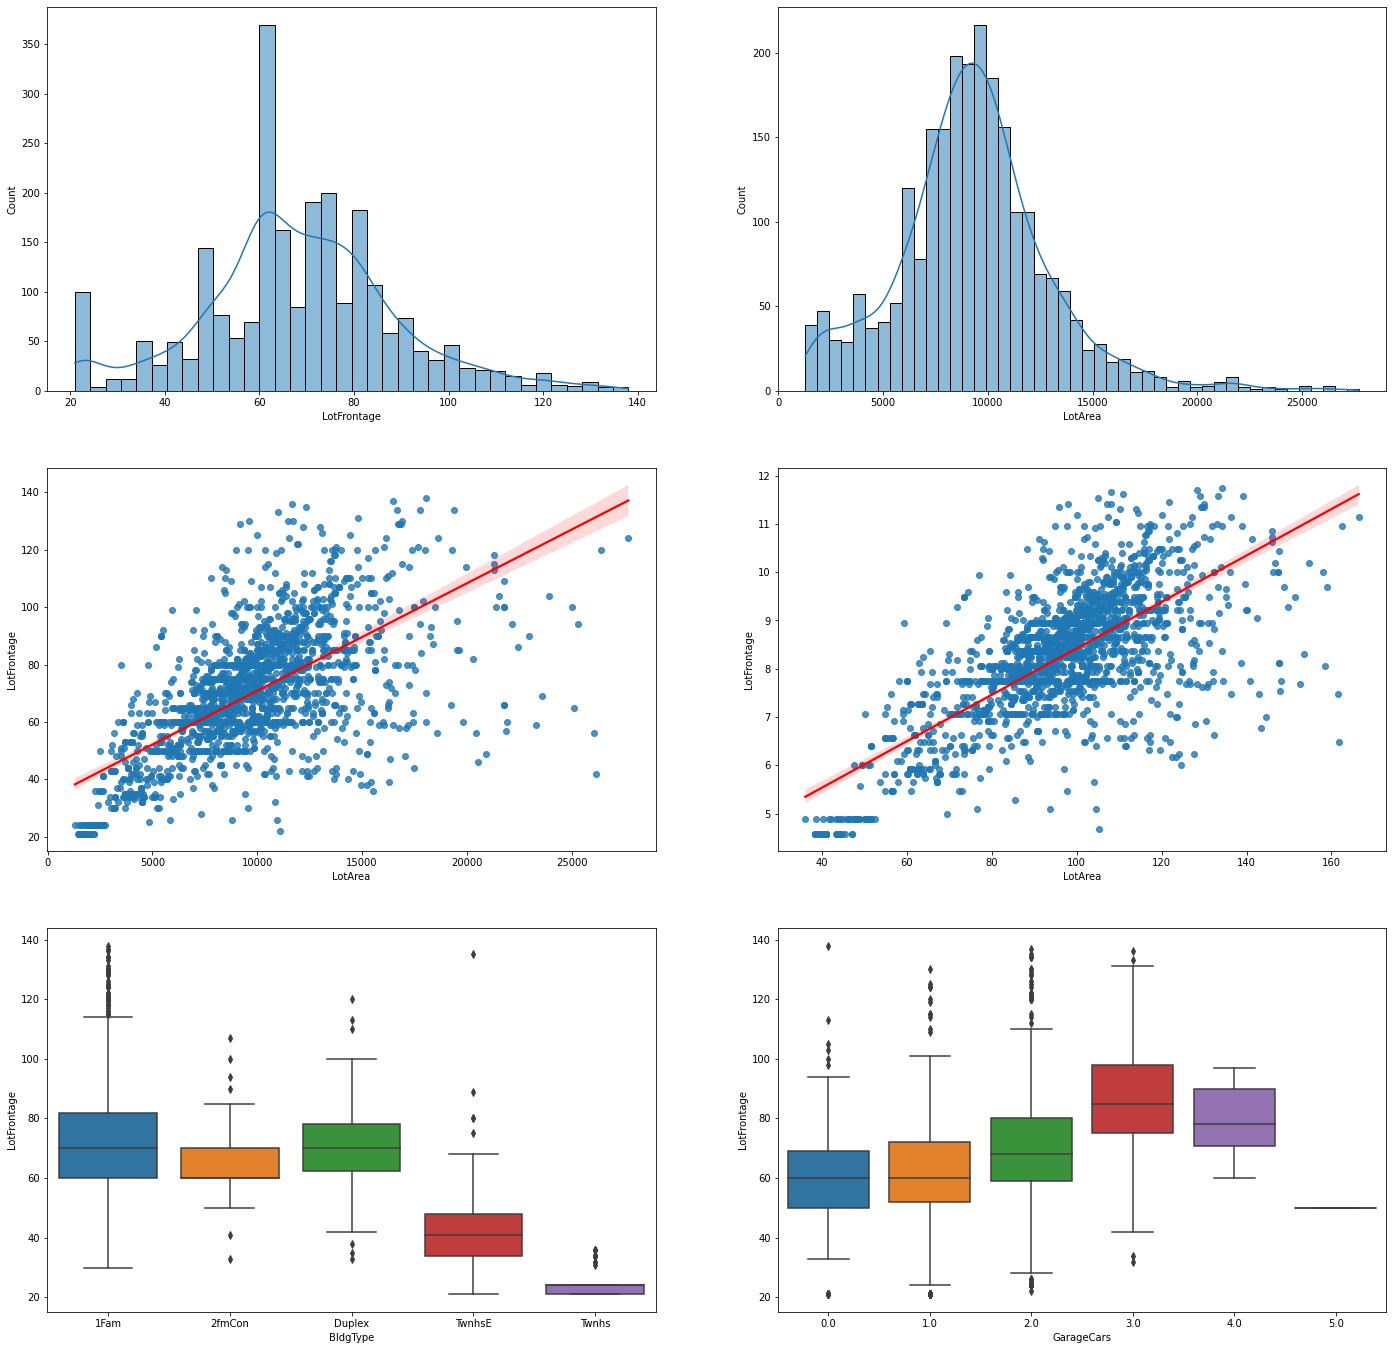

In [15]:
_, ax = plt.subplots(3, 2, figsize=(24, 24))
sns.histplot(x=lot_tmp_z.LotFrontage, kde=True, ax=ax[0,0]);
sns.histplot(x=lot_tmp_z.LotArea, kde=True, ax=ax[0,1]);
sns.regplot(x=lot_tmp_z.LotArea, y=lot_tmp_z.LotFrontage,
            line_kws={"color":"red"}, ax=ax[1,0]);
sns.regplot(x=lot_tmp_z.LotArea.apply(np.sqrt), y=lot_tmp_z.LotFrontage.apply(np.sqrt),
            line_kws={"color":"red"}, ax=ax[1,1]);
# Dwelling type vs LotFrontage
sns.boxplot(x=data.BldgType, y=lot_tmp_z.LotFrontage, ax=ax[2,0])
sns.boxplot(x=data.GarageCars, y=lot_tmp_z.LotFrontage, ax=ax[2,1])

First and second row of plots shows the distribution of lot frontage (Length of the property directly connected to the street) versus the area. Obviously, these are associated.

The categories in the third row are also sensible. More cars / more people the dwelling would expect to house, the greater the lot frontage.


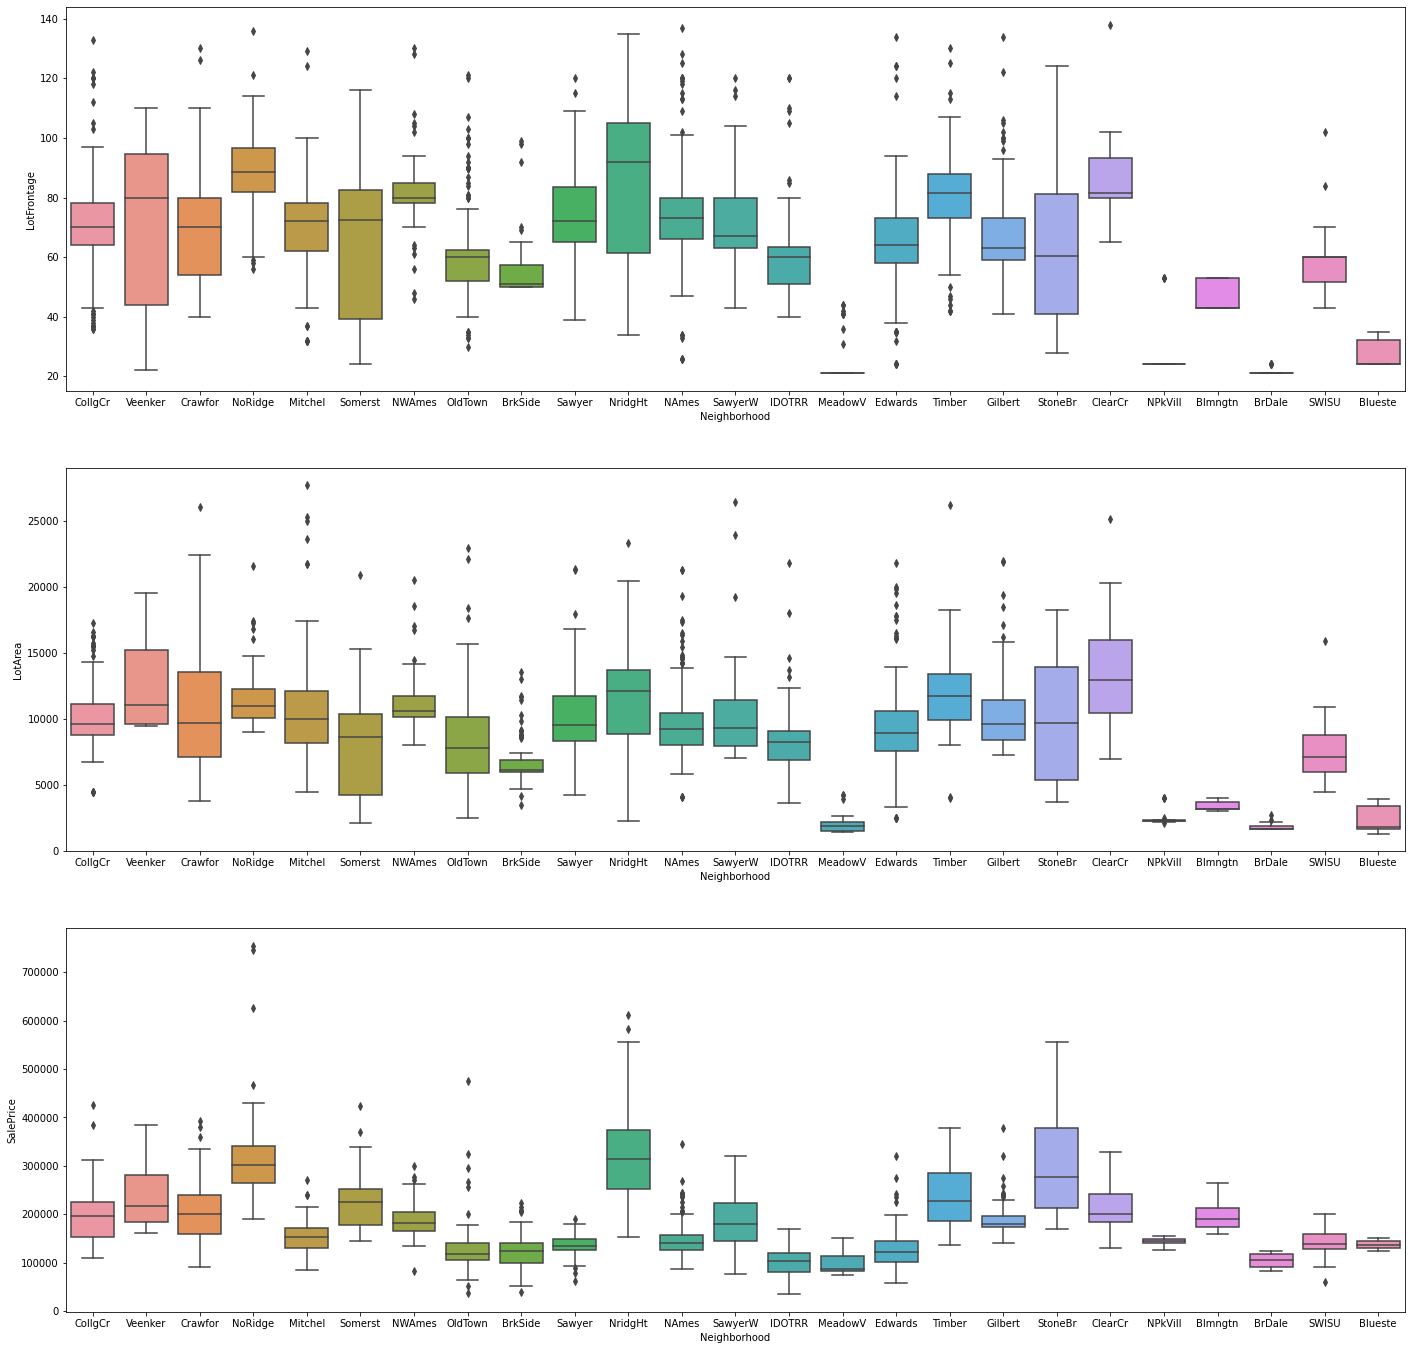

In [16]:
_, ax = plt.subplots(3, 1, figsize=(24, 24))
sns.boxplot(x=data.Neighborhood, y=lot_tmp_z.LotFrontage, ax=ax[0]);
sns.boxplot(x=data.Neighborhood, y=lot_tmp_z.LotArea, ax=ax[1]);
sns.boxplot(x=data[:1460].Neighborhood, y=target, ax=ax[2]);

Train a model to predict LotFrontage and use it to fill missing values

In [17]:
lf_df = pd.get_dummies(data[['LandSlope', 'BldgType', 'LotConfig', 'MSZoning', 'Neighborhood', 
                            'LotArea', 'LotFrontage']].copy())
# Sqrt lot area
lf_df['LotArea']=lf_df['LotArea'].apply(np.sqrt)

# Mask-separate missing from available data
mask = ~lf_df.LotFrontage.isnull()

lf_train = lf_df.loc[mask]
lf_test = lf_df.loc[~mask].drop('LotFrontage', axis=1)

# remove outliers
z = np.abs(stats.zscore(lf_train[['LotFrontage', 'LotArea']]))
lf_train = lf_train[(z < 3).all(axis=1)]

# Scale
scaler = StandardScaler()
X = scaler.fit_transform(lf_train.drop('LotFrontage', axis=1))

# Define target
y = lf_train['LotFrontage']

# Train test split
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.3, random_state=42)

model = GradientBoostingRegressor(n_estimators=30,
                                 min_samples_split=2,
                                 min_samples_leaf=11,
                                 max_features='auto',
                                 max_depth=None)
model.fit(xtrain, ytrain)
ypred = model.predict(xvalid)
gb_results = mae(yvalid, ypred)
mean_result = mae(yvalid, [yvalid.mean()]*len(yvalid))
median_result = mae(yvalid, [yvalid.median()]*len(yvalid))

print("MAE: ", gb_results)

MAE:  8.164497372679337


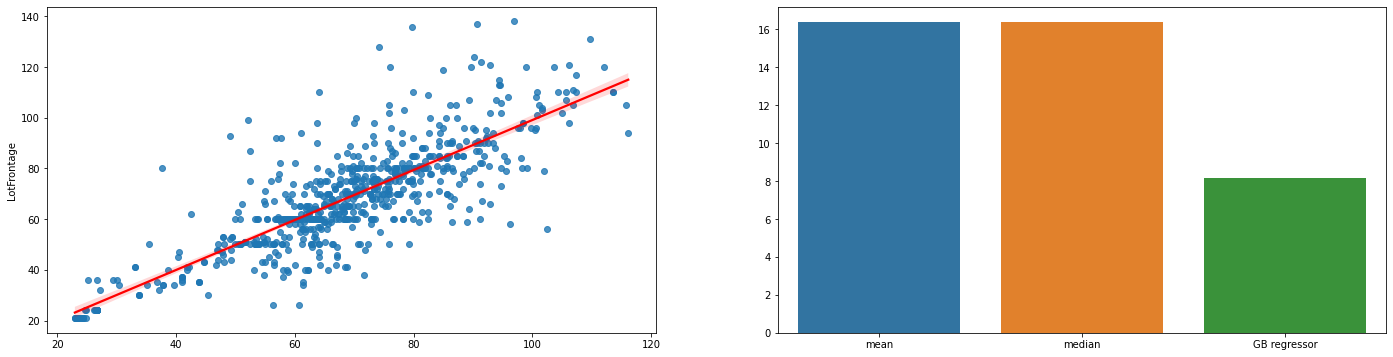

In [18]:
# --- Visualise regression

_, ax = plt.subplots(1, 2, figsize=(24, 6))
sns.regplot(x=ypred, y=yvalid, line_kws={"color":"red"}, ax=ax[0]);
sns.barplot(x=["mean", "median", "GB regressor"], y=[mean_result, median_result, gb_results], ax=ax[1]);

In [19]:
# --- Use model params to fill missing values
lf_test = scaler.transform(lf_test)
lf_missing = model.predict(lf_test)

data.loc[~mask, 'LotFrontage'] = lf_missing

In [20]:
data.describe().T.loc[["LotFrontage"]]

,count,mean,std,min,25%,50%,75%,max
LotFrontage,2919.0,69.50649,22.38403,21.0,59.0,69.0,80.0,313.0


In [21]:
# --- Fill other missings

data.describe().T.sort_values(by="count").head(11)

,count,mean,std,min,25%,50%,75%,max
GarageYrBlt,2760.0,1978.113406,25.574285,1895.0,1960.0,1979.0,2002.0,2207.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtHalfBath,2917.0,0.061364,0.245687,0.0,0.0,0.0,0.0,2.0
BsmtFullBath,2917.0,0.429894,0.524736,0.0,0.0,0.0,1.0,3.0
GarageCars,2918.0,1.766621,0.761624,0.0,1.0,2.0,2.0,5.0
GarageArea,2918.0,472.874572,215.394815,0.0,320.0,480.0,576.0,1488.0
TotalBsmtSF,2918.0,1051.777587,440.766258,0.0,793.0,989.5,1302.0,6110.0
BsmtUnfSF,2918.0,560.772104,439.543659,0.0,220.0,467.0,805.5,2336.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0
BsmtFinSF2,2918.0,49.582248,169.205611,0.0,0.0,0.0,0.0,1526.0


In [22]:
# Reading the variable descriptions, these missing values are houses *without* garages. Make them 0
# Same or similar for the remaining missing values.
data[["GarageYrBlt", 'GarageType']].loc[data.GarageYrBlt.isnull()]

,GarageYrBlt,GarageType
39,NaN,NA
48,NaN,NA
78,NaN,NA
88,NaN,NA
89,NaN,NA
...,...,...
2893,NaN,NA
2909,NaN,NA
2913,NaN,NA
2914,NaN,NA


In [23]:
data['GarageYrBlt'].fillna(0, inplace=True)
data['BsmtHalfBath'].fillna(data.BsmtHalfBath.median(), inplace=True)
data['BsmtFullBath'].fillna(data.BsmtFullBath.median(), inplace=True)
data['GarageCars'].fillna(0, inplace=True)
data['TotalBsmtSF'].fillna(data.TotalBsmtSF.median(), inplace=True)
data['BsmtFinSF2'].fillna(data.BsmtFinSF2.median(), inplace=True)
data['BsmtUnfSF'].fillna(0, inplace=True)
data['GarageArea'].fillna(0, inplace=True)
data['BsmtFinSF1'].fillna(data.BsmtFinSF1.median(), inplace=True)
data['MasVnrArea'].fillna(data.MasVnrArea.median(), inplace=True)

In [24]:
# --- Save cleaned up data
data.to_csv("../data/house-prices-advanced-regression-techniques/cleaned_data.csv")

# Exploration
- Correlation matrix
- Correlation of features with target and other features
- Distribution of importance

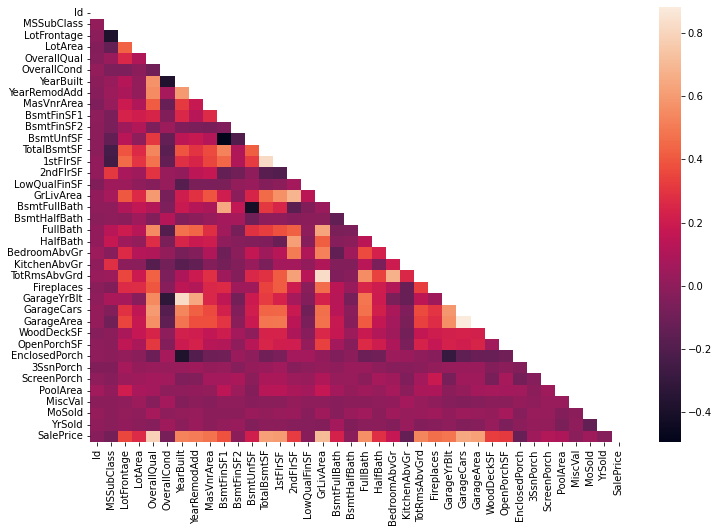

In [25]:
corr = train.corr()
upper_triangle = np.triu(corr)

_, ax = plt.subplots(1, figsize=(12, 8))
sns.heatmap(corr, mask=upper_triangle, ax=ax);

In [26]:
# Sort correlations with target

train.corrwith(target).sort_values(ascending=False).head(20)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
dtype: float64

In [27]:
# Sort correlations between features
threshold = 0.5
all_corrs = data.corr()
feat_corrs = np.where(np.abs(all_corrs) > threshold)
feat_corrs = [(all_corrs.iloc[x, y], x, y) for x, y in zip(*feat_corrs) if x != y and x < y]

feat_correlations = pd.DataFrame(columns=["pair", "corr"])
for w, c in enumerate(feat_corrs):
    corr, i, j = c
    feat_correlations.loc[w] = [all_corrs.index[i]+ " x " + all_corrs.index[j], corr]

In [28]:
feat_correlations.sort_values(by="corr", ascending=False)

,pair,corr
24,GarageCars x GarageArea,0.889890
19,GrLivArea x TotRmsAbvGrd,0.808354
11,TotalBsmtSF x 1stFlrSF,0.801638
21,BedroomAbvGr x TotRmsAbvGrd,0.669737
13,2ndFlrSF x GrLivArea,0.655085
10,BsmtFinSF1 x BsmtFullBath,0.638911
17,GrLivArea x FullBath,0.630286
7,YearBuilt x YearRemodAdd,0.612235
14,2ndFlrSF x HalfBath,0.611362
5,OverallQual x GarageCars,0.600743


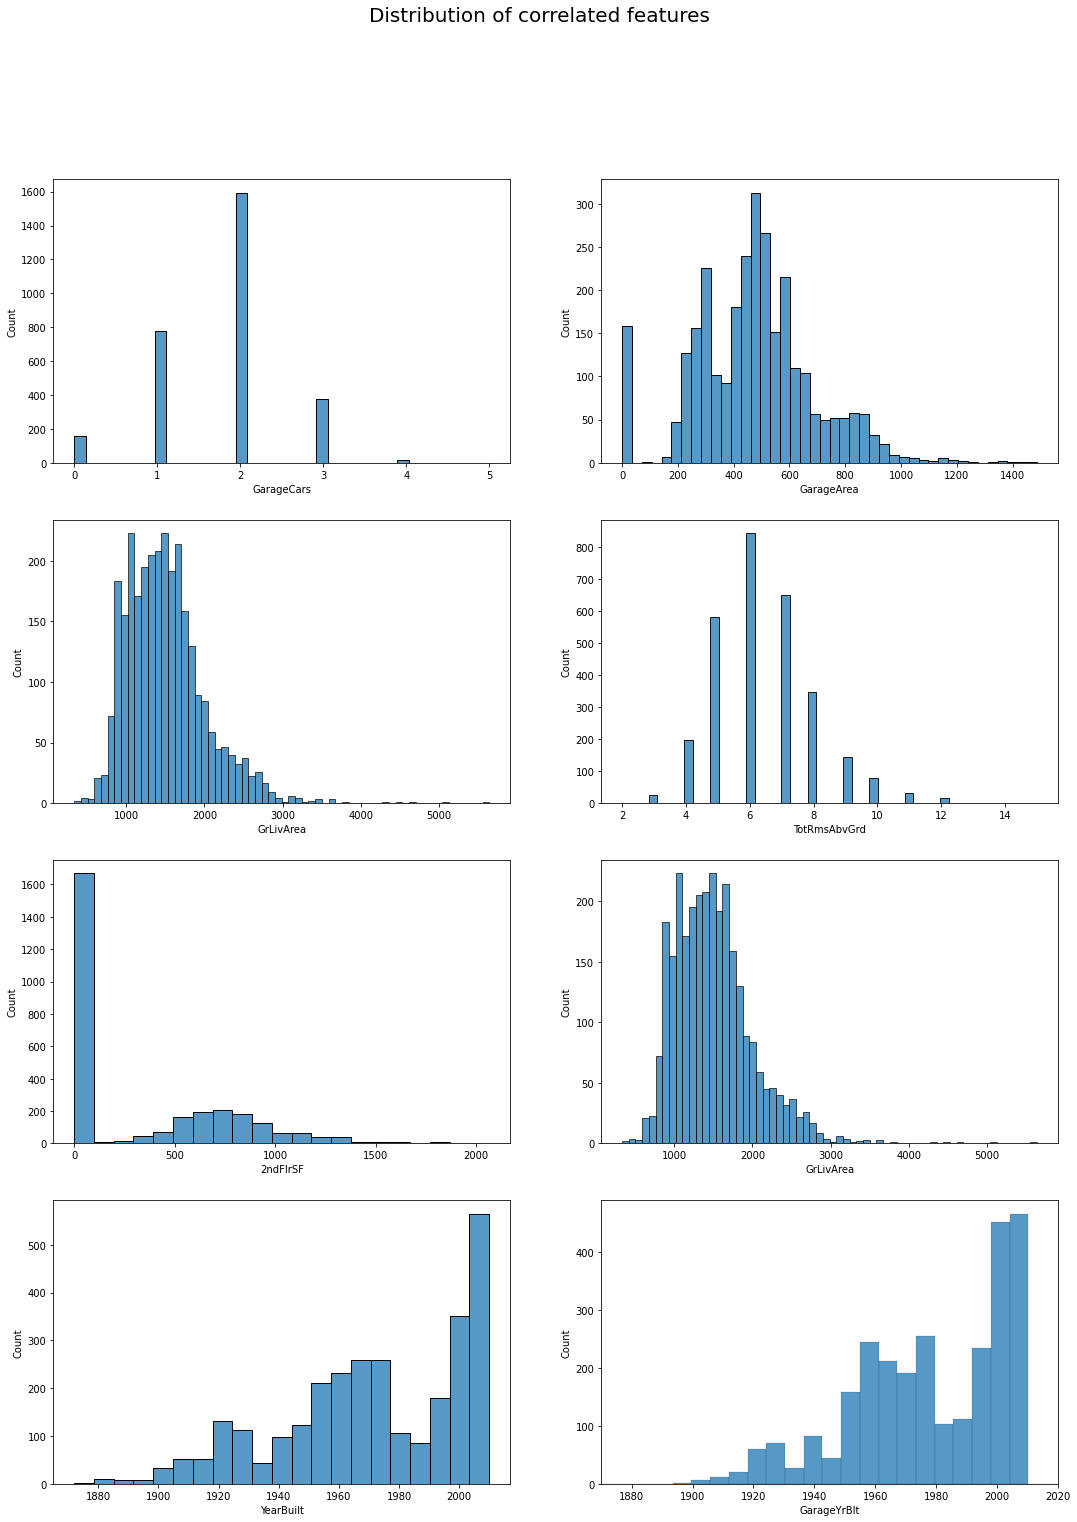

In [29]:
# Distribution of importance
important = ["GarageCars", 'GarageArea', 'GrLivArea', 'TotRmsAbvGrd', '2ndFlrSF', 
             'GrLivArea', 'YearBuilt', 'GarageYrBlt']
_, axes = plt.subplots(4, 2, figsize=(18, 24))
_.suptitle("Distribution of correlated features", size=20)
axes = axes.flatten()

for i in enumerate(important):
    sns.histplot(data[i[1]], ax=axes[i[0]]);
axes[-1].set(xlim=[1870, 2020]);

# Select, Modify, Engineer Variables

In [30]:
# remove GarageYrblt. It's almost identical to year built.
df = data.copy()
df.drop("GarageYrBlt", axis=1, inplace=True)

In [31]:
# --- Modifications and new variables

# log the continuous
log_me = ['GrLivArea', '1stFlrSF', 'LotFrontage', 'LotArea']
for x in log_me:
    df["log" + x] = df[x].apply(np.log)

# Age at sale
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
# total rooms
df['TotalRooms'] = df['BedroomAbvGr'] + df['TotRmsAbvGrd']
# Area vibes
df['AreaVibes'] = np.sqrt(df['OverallQual']) * df['GrLivArea']
# Total square footage
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
# porch stuff
df['TotalPorch'] = df.ScreenPorch + df.EnclosedPorch + df.OpenPorchSF + df.WoodDeckSF + df['3SsnPorch']
# Overall condition
df['OverallQualCond'] = df['OverallCond'] * df['OverallQual']
# Weighted Baths above ground
df['TotalBathsAbv'] = 2 * df['FullBath'] + 0.5 * df['HalfBath']
# Weighted baths below ground
df['TotalBathsBsmt'] = 2 * df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']

In [32]:
# Turn Discrete objects into values

discretes = df.columns[df.isin(['Gd']).any()]
chart = {
    'No': 0, 'None': 0, 'NA': 0, 'Mn': 1, 'Av': 3,
    'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
}
for d in discretes:
    df[d] = df[d].map(chart)

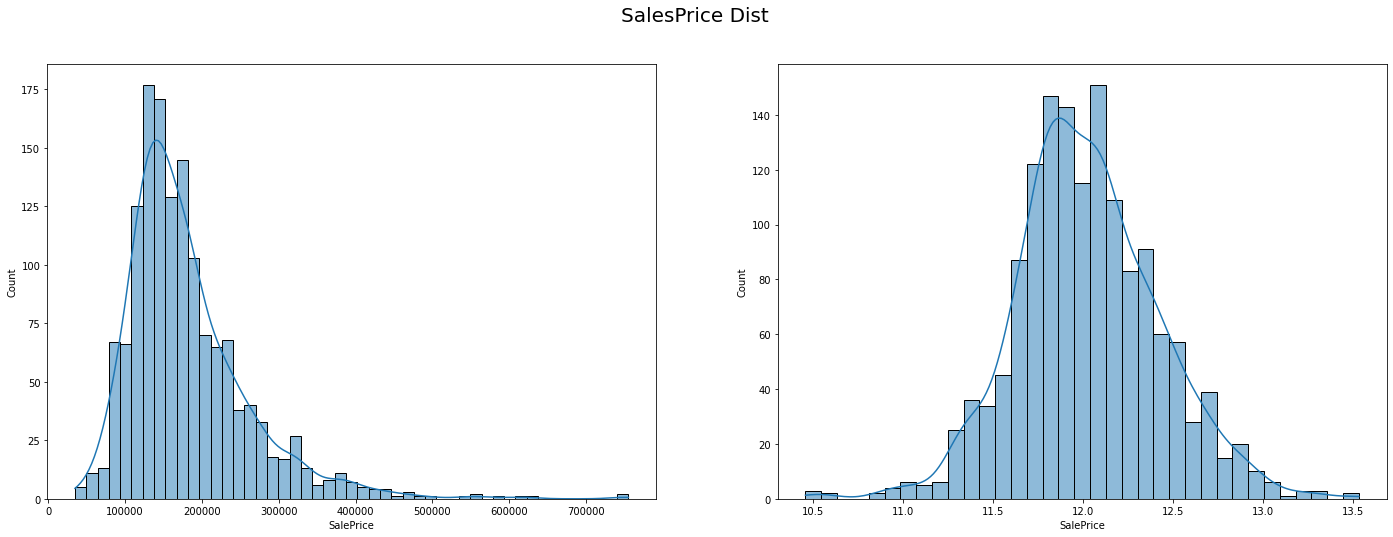

In [33]:
# --- Visualise Sale prices

_, ax = plt.subplots(1, 2, figsize=(24, 8))
_.suptitle("SalesPrice Dist", fontsize=20)

sns.histplot(target, ax=ax[0], kde=True);
sns.histplot(np.log(target), ax=ax[1], kde=True);

In [34]:
target = target.apply(np.log)

In [35]:
# Transform cateogrical 

dfen = df.copy()
for k, v in dfen.items():
    if pd.api.types.is_string_dtype(v):
        dfen[k] = v.astype("category").cat.as_ordered()

for k, v in dfen.items():
    if not pd.api.types.is_numeric_dtype(v):
        dfen[k] = pd.Categorical(v).codes+1

### Split train/test

- split
- remove outliers
- define variables
- define score
- get scores
- stack winners
- fit stack
- validate score


In [36]:
dfen.drop("Id", axis=1, inplace=True)
train_df = dfen[:1460].copy()
train_df['SalePrice'] = target
test_df = dfen[1460:].copy()

In [37]:
train_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'Ope

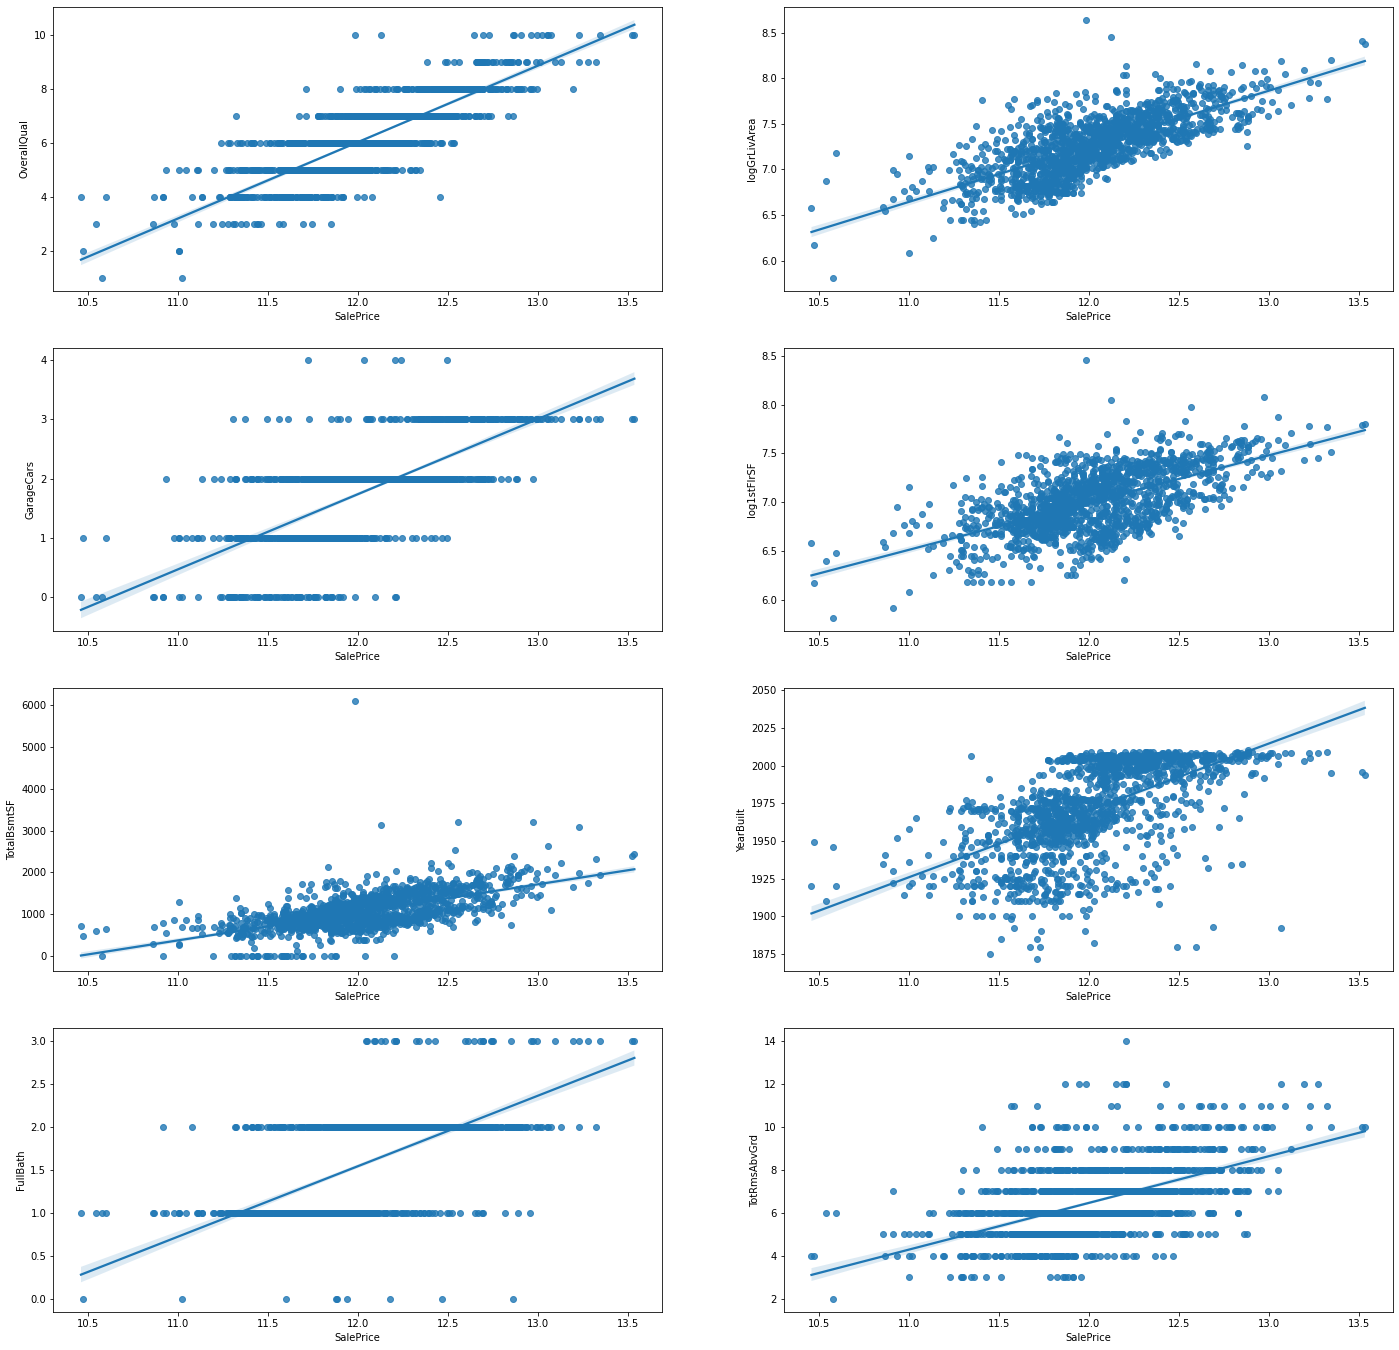

In [38]:
_, axes = plt.subplots(4, 2, figsize=(24, 24))
axes = axes.flatten()
important_features = ['OverallQual', 'logGrLivArea', 'GarageCars', 'log1stFlrSF',
                     'TotalBsmtSF', 'YearBuilt','FullBath', 'TotRmsAbvGrd']
for i, f in enumerate(important_features):
    sns.regplot(x=train_df['SalePrice'], y=train_df[f], ax=axes[i])

In [39]:
# --- Haircut

numeric = train_df.columns

z = np.abs(stats.zscore(train_df[numeric]))
train_dfz = train_df.copy()[(z < 10).all(axis=1)]

In [40]:
train_dfz.shape

(1422, 91)

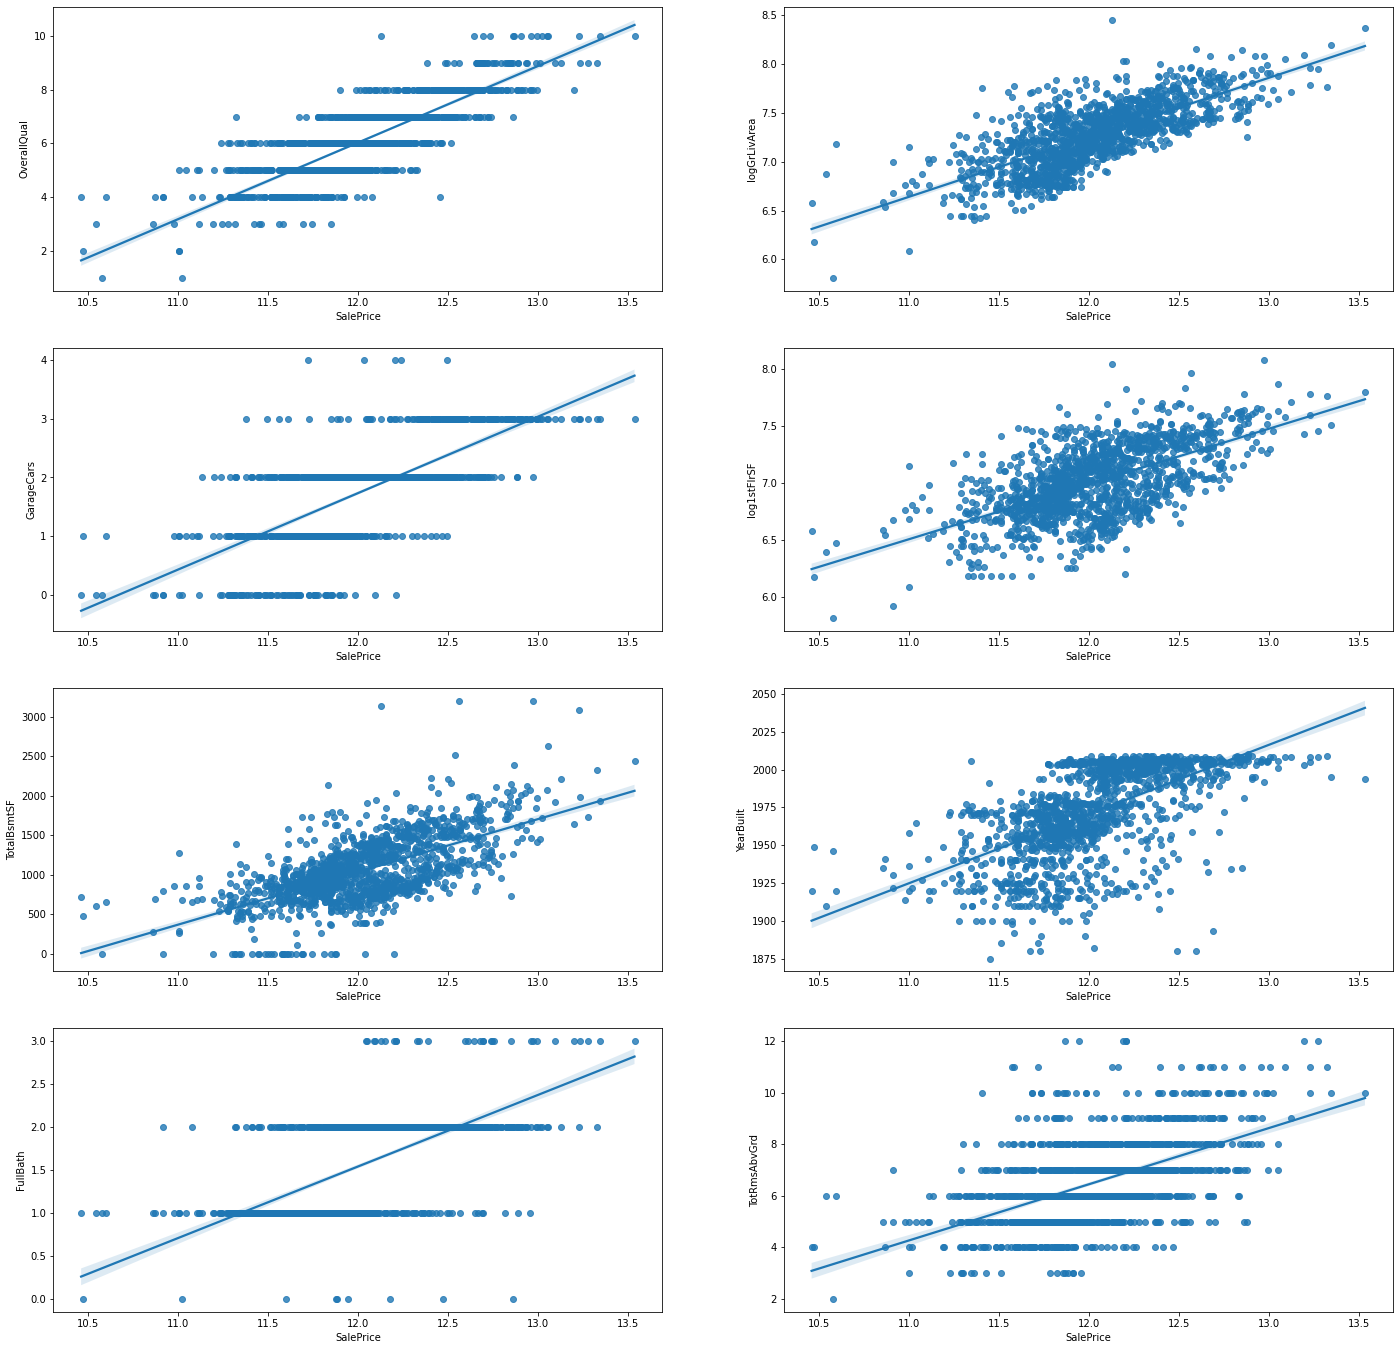

In [41]:
_, axes = plt.subplots(4, 2, figsize=(24, 24))
axes = axes.flatten()
important_features = ['OverallQual', 'logGrLivArea', 'GarageCars', 'log1stFlrSF',
                     'TotalBsmtSF', 'YearBuilt','FullBath', 'TotRmsAbvGrd']
for i, f in enumerate(important_features):
    sns.regplot(x=train_dfz['SalePrice'], y=train_dfz[f], ax=axes[i])

In [46]:
# Drops

to_drop = [
    "SalesPrice",
]

to_drop = to_drop[:1]

In [43]:
not_relevant = train.corrwith(target).sort_values(ascending=False).tail(20)
not_relevant[np.abs(not_relevant) < 0.6]

2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209044
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057329
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
dtype: float64

In [60]:
# Define variables
y = train_dfz['SalePrice']
X = train_dfz.drop('SalePrice', axis=1)


# scale
new_scaler = StandardScaler()
X_scaled = new_scaler.fit_transform(X)

# Split train train/validate
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

In [61]:
# Scores

def v_score(model):
    v_pred = model.predict(X_valid)
    return np.sqrt(mse(y_valid, v_pred))

def cv_score(model, X, y):
    return np.mean(np.sqrt(-cross_val_score(model, X, y, 
                                            scoring="neg_mean_squared_error", cv=5, n_jobs=-1)))

In [62]:
# Models

m_names = ['RandomForestRegressor', 'GradientBoostingRegressor', 'XGBRegressor',
          'svm.SVR', 'ExtraTreesRegressor', 'Lasso']
models = [RandomForestRegressor(), GradientBoostingRegressor(), XGBRegressor(), svm.SVR(),
         ExtraTreesRegressor()]#, Lasso(alpha=0.00005, tol=0.001)]

In [63]:
# Score each model
# scores = [v_score(model.fit(X_train, y_train)) for model in models]
scores =[]

for model in models:
    model.fit(X_train, y_train)
    scores.append(v_score(model))
scores

[0.12056527950688985,
 0.10771752492017944,
 0.11337663988961198,
 0.1391964696310293,
 0.11441771961076337]

In [64]:
# RandomForest Param hunt

randforest_grid = {
    "min_samples_split" : np.arange(2, 10, 1),
    "min_samples_leaf" : np.arange(2, 100, 1)
}
rf_model = RandomizedSearchCV(RandomForestRegressor(), param_distributions=randforest_grid, 
                              n_iter=100, cv=5, verbose=True)
rf_model.fit(X_train, y_train)
print("Best Params : ", rf_model.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Params :  {'min_samples_split': 3, 'min_samples_leaf': 2}


In [65]:
# GradientBoostinRegressor Param hunt

gb_grid = {
    "min_samples_split" : np.arange(2, 10, 1),
    "min_samples_leaf" : np.arange(2, 100, 1),
    "max_depth" : np.arange(2, 5, 1)
}
gb_model = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=gb_grid, 
                              n_iter=100, cv=5, verbose=True)
gb_model.fit(X_train, y_train)
print("Best Params : ", gb_model.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Params :  {'min_samples_split': 7, 'min_samples_leaf': 20, 'max_depth': 2}


In [66]:
# GradientBoostinRegressor Param hunt

svm_grid = {
    "coef0" : np.linspace(0, 1, 25)
}
svm_model = RandomizedSearchCV(svm.SVR(), param_distributions=svm_grid, 
                              n_iter=100, cv=5, verbose=True)
svm_model.fit(X_train, y_train)
print("Best Params : ", svm_model.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/jonathankim/.pyenv/versions/.mlenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 25 is smaller than n_iter=100. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Params :  {'coef0': 0.0}


In [67]:
# Param hunt XGBoost
GBOOST_grid = {"max_depth" :  np.arange(2, 10, 1),
#                "splitter" : ['best','random'],
              "min_samples_split": np.arange(2, 100, 1),
              "min_samples_leaf" : np.arange(2, 100, 1),}
GBOOST_model = RandomizedSearchCV(GradientBoostingRegressor(),
                                  param_distributions=GBOOST_grid, n_iter=100, cv=5, verbose=True)
GBOOST_model.fit(X_train, y_train)
# Show best parameters
print("Best Params : ", GBOOST_model.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [68]:
# Stack models with ideal params

def get_stack():
    
    # define models with tuned params
    level0 = []
    level0.append(("GBOOST", GradientBoostingRegressor(min_samples_split=7, 
                                                       min_samples_leaf=20,
                                                      max_depth=2)))
    level0.append(("RandomForest", RandomForestRegressor(min_samples_split=3, 
                                                         min_samples_leaf=2)))
    level0.append(("svm.SVR", svm.SVR(kernel="poly", gamma="scale", degree=1, coef0=0)))
#     level0.append(("XGB", XGBRegressor(colsample_bytree=??, gamma=?)))
#     level0.append(("ExtraTrees", ExtraTreesRegressor(min_samples_split=??,
#                                                      min_samples_leaf=?)))
#     level0.append(("ElasticNet", ElasticNet(alpha=??, l1_ratio=?, random_state=0, tol=?)))
#     level0.append(("Lasso", Lasso(alpha=??, tol=?)))
    level1 = LinearRegression()
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model
m_names.append("StackingRegressor")

In [69]:
# Fit stacked model

stacked_model = get_stack()
stacked_model.fit(X_train, y_train)
"stacked RMSE: ", v_score(stacked_model)

('stacked RMSE: ', 0.10070200663300534)

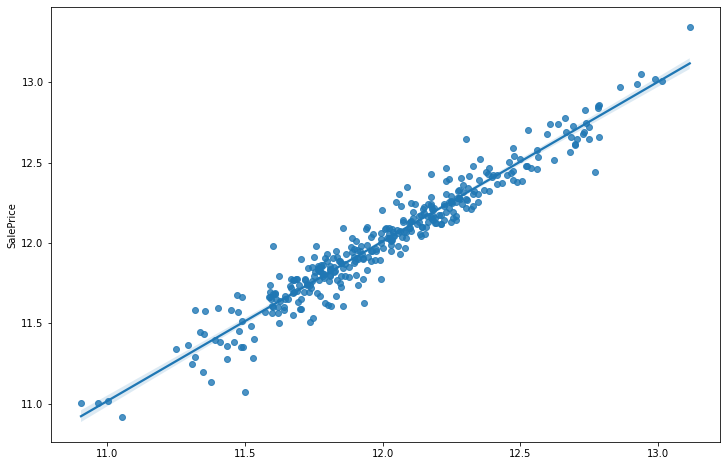

In [70]:
y_pred = stacked_model.predict(X_valid)

_, ax = plt.subplots(1, figsize=(12, 8))
sns.regplot(x=y_pred, y=y_valid, ax=ax);